## Create Extreme Year Experiments

Notebook 2/X

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

Using the dynamic climate indices files we created in notebook 1/X, we can now create model configuration files to put them to use. This notebook outputs 1) pickled dictionaries of per-basin train and test sets and 2) configuration files for both NH and SAC-SMA.

### Import Libraries

In [1]:
#Automatically reload modules; ensures most recent versions
%load_ext autoreload
%autoreload 2

In [2]:
#Import Python libraries
import os
import sys
import copy
import random
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#Import NeuralHydrology functions
from functions import config
from functions.utils import load_basin_file

### Define Parameters

##### Most Important Experiment Parameters

First, we define which models we want to create configuration files for. The main components include 1) which models we want to create config files for, 2) what type of climate inputs we want to include in the model, 3) type of experiment, defined by the nature of the train and test splits, 4) the forcing source, and 5) the range of years the train and test years are chosen from.

This notebook can create configuration files for both NH and SAC-SMA simultaneously, as well as individually. This can be decided through the set Boolean variables, "nh" and "sacsma". The "inputs" variable refers to the nature of the climate inputs to be included in the NH LSTM model. To include the static CAMELS climate attributes values (Addor et al., 2017), inputs should be set to "static". To include the updating dynamic climate indices we created in notebook 1/X, inputs should be set to "dynamic". The experiment type variable, "exp_type", refers to the nature of the train test sets to be used in the model. These can either be "extreme", meaning the train and test sets are composed of years characterized by an extreme climate value, or "random, meaning the train and test sets are composed of years randomly chosen. The "forcing" variable defines the forcing source of the climate inputs. The forcing sources avaliable through the CAMELS dataset include "daymet", "maurer", "maurer_extended", "nldas", and "nldas_extended". Lastly, the "years" variable determines the range of years the train and test sets can pull from. The options are "all", referring to all years avaliable through CAMELS (1980-2014), and "nwm", refering to the years also avaliable for the National Water Model (NWM; 1995-2014). This option is included so that the NWM can be used as a benchmark model to the LSTM and SAC-SMA models.

It is important to note that SAC-SMA does not accept static climate attributes or dynamic climate indices.

In [3]:
#########################################################################################

#Create SAC-SMA configuration files? 
sacsma = False
#Create NH configuration files?
nh = True

#Climate index input type: 'static' or 'dynamic'
# NOTE: SAC-SMA DOES NOT ACCEPT STATIC OR DYNAMIC CLIMATE INPUTS
inputs = 'dynamic'

#Experiment type: train/test on 'extreme' or 'random' years
exp_type = 'random'

#Forcing source: CAMELS forcing data source? (daymet', 'nldas'(_extended'), 'maurer'(_extended'))
forcing = 'nldas_extended'

#Range of years train/test sets sourced from: 'all' or 'nwm'
years = 'nwm'

#########################################################################################

##### Additional Experiment Parameters

To ensure we are using the correct dynamic climate indices file, we need to explicitly state the basin list number and length of the mean rolling window used to create that file. This information can be found in the file's name, saved in the ../config_complementaries/dynamic_climate_indices directory.

In [4]:
#########################################################################################

#Specify number of basins in name of desired dynamic climate indices file
basin_list_num = 531

#Specify rolling mean window length, also found in name of desired dynamic climate indices file
window = 365

#########################################################################################

Now we need to define which dynamic climate indices to create train and test sets and configuration files for. Default is p_mean_dyn and aridity_dyn. This list must consist of the climate indices names in the dynamic climate indices file. We also need to specify how many years we want the train and test sets to consist of. Default for both is 5. If we are creating random experiments, we want to define how many random train and test sets we want to create. These are generally consistent throughout all experiments, meaning only one set of 10 random train test tests will be created, to act as a consistent, unbiased benchmark for the extreme experiments. Lastly, we need to specify the number of ensemble members we want to create (num_seeds; default 10) and which seed we would like to start on.

In [5]:
#########################################################################################

#If exp_type == 'extreme': Which indexes do we want to create extreme train/test sets for
use_climate_indexes = ['aridity_dyn']

#Specify number of years to be used in train and test sets
n_train_years = 5
n_test_years = 5

#If exp_type == 'random': How many random train/test sets do we want to create
num_random_experiments = 5

#Specify number of ensemble members and first random seed value (increases by 1 for n num_seeds)
num_seeds = 10
first_seed = 100

#########################################################################################

##### Notebook Configurations

As a safety measure, variables to control file overwriting are included. If the files already exist, we have to explicitly, and separately, define if we want to overwrite the configuration and/or train/test (dates) files. If we are creating configuration files for a set of random experiments, we need to be careful about overwriting the dates files to maintain a consitent benchmark for the extreme models. Also, if we want the resulting plots to be interactive, set interactive_plots to True; if we want plots to be inline, set it to False. For this notebook, it is not additive.

In [6]:
#########################################################################################

#Overwrite existing configuration files?
overwrite_configs = True

#Overwrite existing train/test date files? TYPICALLY FALSE FOR RANDOM EXPERIMENTS
overwrite_dates = False

#Define if in-notebook plots are interactive (typically not needed)
interactive_plots = False

#########################################################################################

##### Paths

Now we define the paths to different directories and files. If the native repository and naming structure is being used, it is unlikely that any changes will have to be made. Several of the filepaths and names are dynamically determined by the experimental variables we defined above.

Notice that the climate_indices_file is hardcoded with respect to basin list and rolling mean window length (see notebook 1/x).

In [7]:
#########################################################################################

#Path to working directory (where this notebook is)
working_dir = Path(os.getcwd())

#Path to "configs" directory (../config_complementaries)
config_comp_dir = working_dir / 'config_complementaries'

#Path to folder to save train/test sets to
dates_dir = config_comp_dir / 'train_test_sets'

#Path to camels basin_dataset_public_v1p2 dir (to be included in config)
camels_dir = working_dir / 'camels' / 'basin_dataset_public_v1p2'

#Path to NeuralHydrology codebase ('../neuralhydrology/neuralhydrology')
nh_dir = working_dir / 'nh' / 'neuralhydrology' / 'neuralhydrology'

#Dynamic path to save the SAC-SMA configuration files to (based on defined variable values)
sacsma_configs_path = working_dir / f'sacsma/configs/{exp_type}/{forcing}/{years}'

#Dynamic path to save the NH configuration files to (based on defined variable values)
nh_configs_path = working_dir / f'nh/configs/{inputs}/{exp_type}/{forcing}/{years}'

#Path to dummy config file (based on defined input type)
dummy_config_file = config_comp_dir / 'dummy_configs' / f'climate_experiment_{inputs}_dummy.yml'

basin_list_path = config_comp_dir / 'basin_lists' / f'{basin_list_num}_basin_list.txt'

#Filepath and name to (load or save a) dynamic climate indexes pickle file
climate_indices_file = config_comp_dir / f'dynamic_climate_indices/dyn_clim_indices_{forcing}_{basin_list_num}basins_{window}.p'

#########################################################################################

**You should not have to edit anything below this cell.**

The variable "holdout_types" can be a confusing naming scheme (@gsnearing). Holdout types are the "type" of years that will be excluded, or _held out_, of the **training** set and ultimately used in the **test** set. Note that these _only_ need to be defined for extreme experiments.

For example, if we want to simulate an increasingly arid climate, represented by the dynamic mean precipitation index (p_mean), we want to **train on high** average p_mean years and **test on low** average p_mean years; this experiment would be called **p_mean_dyn_low**, because years with **low** average p_mean years are excluded from the training set and used in the **test** set.

The cell below orients the notebook based on the parameters specifed above.

In [8]:
#########################################################################################

#Explicitly describe types of extremes
holdout_types = ['low', 'high']

#Create list of seeds from seed variables
seeds = [str(x) for x in list(range(first_seed, first_seed + num_seeds))]

#########################################################################################

#If we are creating random experiments...
if exp_type == 'random':
    
    #Create experiment names consisting of integers (for n num_random_experiments)
    experiments = list(range(num_random_experiments))

#If we are creating extreme experiments...
if exp_type == 'extreme':
    
    #Make an experiment for...
    experiments = []
    
    #...each climate index and...
    for ind in use_climate_indexes:
        
        #Isolate index name from "dyn", in case we are creating static experiments
        ind = ind.split('_dyn')[0]
        
        #...holdout_type...
        for htype in holdout_types:
            
            #Name the experiment according to that index and holdout type
            experiment = f'{ind}_{htype}'
            #Append experiment name to experiments list
            experiments.append(experiment)
    
    #I like having my experiments in alphabetical order
    experiments = list(np.sort(experiments))
    
#########################################################################################

#If forcing == 'nldas_extended'...
if forcing == 'nldas_extended':
    
    #The forcing data column names for NH (ndyns) and SAC-SMA (sdyns) are as follows
    ndyns = ['PRCP(mm/day)','SRAD(W/m2)','Tmax(C)','Tmin(C)','Vp(Pa)']
    sdyns = ['PRCP(mm/day)','SRAD(W/m2)','Tmax(C)','Tmin(C)','Vp(Pa)']
    
#If forcing == 'daymet'...
if forcing == 'daymet' or 'maurer':
    
    #The forcing data column names for NH (ndyns) and SAC-SMA (sdyns) are as follows
#     ndyns = ['prcp(mm/day)','srad(W/m2)','tmax(C)','tmin(C)','vp(Pa)']
    ndyns = ['PRCP(mm/day)','SRAD(W/m2)','Tmax(C)','Tmin(C)','Vp(Pa)']
    sdyns = ['prcp(mm/day)','srad(W/m2)','tmax(C)','tmin(C)','vp(Pa)']
    
#########################################################################################

#Make plots interactive or inline based on interactive_plots variable
if interactive_plots:
    
    %matplotlib notebook
    %matplotlib notebook
    
else:
    
    %matplotlib inline
    
#########################################################################################

### Explicit Warnings

Just to make sure we understand the magnitude of running this notebook, some warnings are printed to remind you of your pre-existing experiments and current overwrite variables.

In [9]:
#If we are creating configurations for NH...
if nh:
    
    #Check if the filepath to the configs already exists, and if it does...
    if os.path.isdir(nh_configs_path) == True:
        
        #Warn us!
        print('\033[91m'+'\033[1m'+'NH exeriments already exist.')

#If we are creating configurations for SAC-SMA...
if sacsma:
    
    #Check if the filepath to the configs already exists, and if it does...
    if os.path.isdir(sacsma_configs_path) == True:
        
        #Warn us!
        print('\033[91m'+'\033[1m'+'SAC-SMA exeriments already exist.')
        
        #If we said we wanted to overwrite config files, that's fine, but...
        if overwrite_configs == True:
    
            #Warn us!
            print('\033[91m'+'\033[1m'+'\nConfiguration files will be overwritten.')

#If we said we wanted to overwrite config files, that's fine, but...
if overwrite_dates == True:
    
    #Warn us!
    print('\033[91m'+'\033[1m'+'Dates files will be overwritten.')
    
#If the climate indices file provided does not exist...
if os.path.exists(climate_indices_file) == False:
    
    #Warn us!
    print('\033[91m'+'\033[1m'+'Provided climate indices file does not exist.')
    
    
#If the basin list file provided does not exist...
if os.path.exists(basin_list_path) == False:
    
    #Warn us!
    print('\033[91m'+'\033[1m'+'Provided basin list file does not exist.')

### Load Source Data

First we need to load in the dynamic climate indices file. If we are creating extreme train and test sets, this file is used to determine the extreme years for the desired climate variables.

In [10]:
#Load pickled dynamic climate indices file
with open(climate_indices_file, 'rb') as f:
    climate_indices = pkl.load(f)
    
#Get list of basins dynamic climate indices were calculated for
basins = list(climate_indices.keys())

#If we are creating experiments for only the NWM years...
if years == 'nwm': 
    
    #For every basin...
    for basin in basins:
        
        #Trim the datetime index to only include data within the NWM range
        climate_indices[basin] = climate_indices[basin].loc[pd.date_range('1995-10-01','2014-12-30',freq='D')]

#Check beginning time step
print("Climate indices beginning at",climate_indices[basins[0]].index[0])

Climate indices beginning at 1995-10-01 00:00:00


We can now take a peek at an example climate index for an example basin.

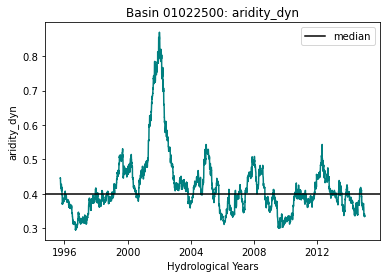

In [11]:
#Plot an example climate index for an example basin
plt.plot(climate_indices[basins[0]][use_climate_indexes[0]],c='teal')
#Draw median line
plt.axhline(y=np.nanmedian(climate_indices[basins[0]][use_climate_indexes[0]]),color='k',label='median')
#Set xlabel
plt.xlabel('Hydrological Years')
#Set ylabel
plt.ylabel(climate_indices[basins[0]][use_climate_indexes[0]].name)
# plt.ylabel('Mean Aridity Index (PET/Precipitation)')
#Set title
plt.title(f'Basin {basins[0]}: {climate_indices[basins[0]][use_climate_indexes[0]].name}')
# plt.title(f'Basin {basins[0]}: Dynamic Mean Aridity Index')
#Show legend
plt.legend()
#Show plot
plt.show()

In [12]:
#If interactive plots enabled, must explicitly close plot
plt.close()

### Create Train/Test Sets

There are several steps for creating the train andtest sets for the extreme climate experiments: we need to 1) define the train/test split function, 2) create the train and test sets using that function, and 3) save the train and test sets in the dates_dir (constituting the first external save of this notebook). 

But first, for fun, let's conceptualize how the extreme train and test sets are created.

##### Visualization

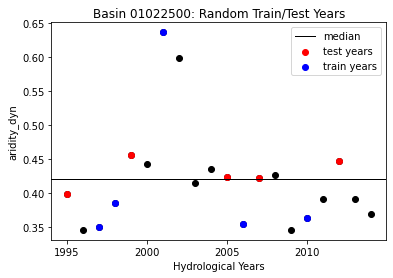

In [13]:
#Create a dataframe of an example basin for an example index and sort based on index value
ci_srt = climate_indices[basins[0]].dropna(0).sort_values(use_climate_indexes[0])

#Create 'year' column by extracting the years from the dataframe's datetime index
ci_srt['year'] = ci_srt.index.year
#Extract the year column
a = ci_srt.pop('year')
#Re-insert the 'year column into the first column position'
ci_srt.insert(value=a,column='year',loc=0)

#Create a list of hydro years, sorted temporally
xs = [int(x) for x in list(ci_srt.groupby('year').mean().index)]
#Create a list of mean climate index values, sorted temporally
ys = list(ci_srt.groupby('year').mean()[use_climate_indexes[0]])

#Create a list of sorted years, sorted by mean climate index values
sorted_years = list(ci_srt.groupby('year').mean().sort_values(use_climate_indexes[0]).index)  
    
#If we are creating extreme train/test sets...
if exp_type == 'extreme':

    #Create a list of sorted mean climate index values, sorted by mean climate index value
    sorted_ys = list(ci_srt.groupby('year').mean().sort_values(use_climate_indexes[0])[use_climate_indexes[0]])
    #Get a list of train years (one extreme)
    train_years = sorted_years[:5]
    #Get a list of train years' climate index values
    train_ys = sorted_ys[:5]
    #Get a list of test years (opposite extreme)
    test_years = sorted_years[-5:]
    #Get a list of test years' climate index values
    test_ys = sorted_ys[-5:]
    
if exp_type == 'random':
    
    #Zip sorted_years and ys together to maintain year, value relationship during shuffle
    temp = list(zip(sorted_years,ys))
    #Shuffle them
    np.random.shuffle(temp)
    #Unzip them
    random_years, random_ys = zip(*temp)
    
    #Get a list of train years
    train_years = random_years[:5]
    #Get a list of train years' climate index values
    train_ys = random_ys[:5]
    #Get a list of test years
    test_years = random_years[-5:]
    #Get a list of test years' climate index values
    test_ys = random_ys[-5:]

#Plot years and their corresponding climate index values
plt.scatter(xs,ys,color='k')

#Counters to limit setting labels once for each set
itrain = 0
itest = 0

#For every x,y pair in xs (years) and ys (values)...
for x,y in zip(xs,ys):
    
    #If y (value) is in train_ys...
    if y in train_ys:
        #Add 1 to itrain
        itrain = itrain + 1
        #And if itrain is equal to 1...
        if itrain == 1:
            
            #Plot year and value as blue point and label
            plt.scatter(x,y,color='blue',label='train years')
            
        #If itrain is not equal to 1...
        else:
            
            #Plot year and value as blue point
            plt.scatter(x,y,color='blue')
            
    #Or if y (value) is in test_years...
    if y in test_ys:
        
        #Add 1 to itest
        itest = itest + 1
        #And if itest is equal to 1...
        
        if itest == 1:
            
            #Plot year and value as red point and label
            plt.scatter(x,y,color='red',label='test years')
            
        #If itest is not equal to one...
        else:
            
            #Plot year and value as red point
            plt.scatter(x,y,color='red')

#Set x-axis tick interval
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
#Draw line of median climate value
plt.axhline(y=np.mean(climate_indices[basins[0]][use_climate_indexes[0]]),
            color='k',lw=1,label='median')

#Set x-axis label
plt.xlabel('Hydrological Years')
#Set y-axis label
plt.ylabel(f'{use_climate_indexes[0]}')
# plt.ylabel(f'Mean Aridity Index')
#Set title
plt.title(f'Basin {basins[0]}: {exp_type.capitalize()} Train/Test Years')
# plt.title(f'Basin {basins[0]}: Random Train/Test Sets')
#Show legend
plt.legend(loc=0)
#Show plot
plt.show()

##### Define split function

Here we create a function that orders data depending on the holdout type ("high" reverses the order of the argsorted list initialized later on), grabs the first n years for the test set and last n years for train set. It is important to understand this function, as it is the origin of the train and test sets.

In [14]:
#Define a function that splits train and test years based on climate values
def train_test_split(idx, holdout, n_train, n_test):

    #If the holdout type is high, reverse the argsort so that high index values are the test set (as seen below)
    if holdout == 'high':
        idx.reverse()
        
    #Grab the first few years as the test set
    test = idx[:n_test]
    
    #Remove anything within sequence length of these years
    for t in test:
        try:
            idx.remove(t)
        except: 
            pass
        try:
            idx.remove(t+1)
        except: 
            pass
        try:
            idx.remove(t-1)
        except: 
            pass
    
    #Grab last few years as the train set
    train = idx[-n_train:] 
    
    #Return test and train sets
    return test, train

##### Create train/test sets

In [15]:
#If we are creating experiments for either of the models...
if nh or sacsma:
    
    #Initialize empty train/test dictionaries
    test_dates = {experiment: {basin: {} for basin in basins} for experiment in experiments}
    train_dates = {experiment: {basin: {} for basin in basins} for experiment in experiments}

    #For n experiments...
    for experiment in tqdm(experiments):
        
        #If we are creating extreme train/test sets
        if exp_type == 'extreme':
        
            #Experiment name is split from "_dyn" and rejoin (in case we are creating a static experiment)
            clim_index = "_".join(experiment.split('_')[:-1])+'_dyn'
            htype = experiment.split('_')[-1]

        #And for every basin...
        for b, basin in enumerate(basins):
            basin = str(basin)

            #Retrieve the dates from the index of a basin's climate indices dataframe
            dates = climate_indices[basin].index

            #The following start/end dates correspond to hydrological years
            #Extract any dates that are the 1st day of the 10th month 
            start_dates = climate_indices[basin].loc[(dates.month == 10) & (dates.day == 1)].index
            #Extract any dates that are the 30th day of the 9th month
            end_dates = climate_indices[basin].loc[(dates.month == 9) & (dates.day == 30)].index

            #Exclude the first and last years
            start_dates = start_dates[1:-1]
            #Exclude first two years to ensure there is no incomplete data years
            end_dates = end_dates[2:]

            #If we are making random experiments...
            if exp_type == 'random':

                #Make a list of the start and end dates "zipped" together
                temp = list(zip(start_dates, end_dates))
                #Shuffle the start/end date pairs
                np.random.shuffle(temp)
                #Separate the pairs into start and end dates while keeping them in order
                sorted_start_dates, sorted_end_dates = zip(*temp)

                #Extract first 5 random start/end dates and store them for the corresponding experiment
                test_dates[experiment][basin]['start_dates'] = list(sorted_start_dates[:5])
                test_dates[experiment][basin]['end_dates'] = list(sorted_end_dates[:5])

                #Extract last 5 random start/end dates and store them for the corresponding experiment
                train_dates[experiment][basin]['start_dates'] = list(sorted_start_dates[-5:])
                train_dates[experiment][basin]['end_dates'] = list(sorted_end_dates[-5:])

            #If we are making extreme experiments...
            if exp_type == 'extreme':

                #Get index of all hydrological year end_dates and drop any dates that return a value of NaN
                indexes_end_years = climate_indices[basin].loc[end_dates][clim_index].dropna()                

                #Initialize list of hydrological start date indexes
                indexes_start_years = []

                #For every end date of an extreme year...
                for ed in indexes_end_years.index:

                    #Add the date exactly 364 days before the corresponding end_date to the start_years list
                    indexes_start_years.append(ed + pd.to_timedelta(-364,unit='d'))

                #Extract the numerical index of the start dates
                indexes_start_years = climate_indices[basin].loc[indexes_start_years][clim_index]
                
                #Sort end_year indexes according to their corresponding climate index value
                sorted_indexes_end_years = list(np.argsort(indexes_end_years.values))
                #Make train and test index using train_test_split function
                test_dex, train_dex = train_test_split(sorted_indexes_end_years, htype,
                                                       n_train_years, n_test_years)

                #Store test start & end dates for the corresponding experiment using the test_dex
                test_dates[experiment][basin]['start_dates'] = list(np.sort(list(indexes_start_years.iloc[test_dex].index)))
                test_dates[experiment][basin]['end_dates'] = list(np.sort(list(indexes_end_years.iloc[test_dex].index)))

                #Store train start & end dates for the corresponding experiment using the train_dex
                train_dates[experiment][basin]['start_dates'] = list(np.sort(list(indexes_start_years.iloc[train_dex].index)))
                train_dates[experiment][basin]['end_dates'] = list(np.sort(list(indexes_end_years.iloc[train_dex].index)))

  0%|          | 0/5 [00:00<?, ?it/s]

Unfortunately, the SAC-SMA and NH libraries work with dictionaries of conflicting key-orders for the train and test sets. SAC-SMA is designed to read train and test set dictionaries with the format dict['start/end_dates'][basin] and NH is designed to read train and test set dictionaries with the format dict[basin]['start/end_dates']. This is accounted for below

In [16]:
#If sacsma == True, we need to switch the order of the dictionary keys...
if sacsma:
    
    #Initialize sacsma train & test dictionaries
    sacsma_train_dates = {}
    sacsma_test_dates = {}
    
    #For every experiment...
    for experiment in list(train_dates.keys()):
        
        #Initialize an experiment level
        sacsma_train_dates[experiment] = {}
        sacsma_test_dates[experiment] = {}
        
        #For every start &end date...
        for date in list(train_dates[experiment][basin].keys()):
            
            #Initalize a date level
            sacsma_train_dates[experiment][date] = {}
            sacsma_test_dates[experiment][date] = {}
            
            #And for every basin...
            for basin in list(train_dates[experiment].keys()):
                
                #Input the dataframes made above into the sacsma train & test dictionaries
                sacsma_train_dates[experiment][date][basin] = train_dates[experiment][basin][date]
                sacsma_test_dates[experiment][date][basin] = test_dates[experiment][basin][date]

##### Save train/test sets

The train/test sets are saved as pickled dictionaries in the dates_dir defined above. Notice that these files are named dynamically and that the titles indicate the parameters of the experiment they will be used in.

In [17]:
#For every experiment...
for e, experiment in enumerate(train_dates.keys()):
    
    #If we are creating train/test sets for neuralhydology...
    if nh == True:

        if exp_type == 'extreme':
                
            #If the date file is NOT already in dates_dir folder or if we want to overwrite that file...
            if not os.path.exists(f'nh_train_{exp_type}_{forcing}_{years}_{experiment}.pkl') or overwrite_dates == True:

                #Define name of train/test file according to experiment parameters
                test_fname = Path(f'{dates_dir}/nh_test_{exp_type}_{forcing}_{years}_{experiment}.pkl')
                train_fname = Path(f'{dates_dir}/nh_train_{exp_type}_{forcing}_{years}_{experiment}.pkl')
            
        if exp_type == 'random':
            
            #If the date file is NOT already in dates_dir folder or if we want to overwrite that file...
            if not os.path.exists(f'nh_train_{exp_type}_{years}_{experiment}.pkl') or overwrite_dates == True:

                #Define name of train/test file according to experiment parameters
                test_fname = Path(f'{dates_dir}/nh_test_{exp_type}_{years}_{experiment}.pkl')
                train_fname = Path(f'{dates_dir}/nh_train_{exp_type}_{years}_{experiment}.pkl')

        #Save test file for an experiment at test_fname
        with open(test_fname, 'wb') as f:
            pkl.dump(test_dates[experiment], f)

        #Save train file for an experiment at train_fname
        with open(train_fname, 'wb') as f:
            pkl.dump(train_dates[experiment], f)
        
    #If we are creating train/test sets for SAC-SMA...
    if sacsma == True:

        if exp_type == 'extreme':
                
            #If the date file is NOT already in dates_dir folder or if we want to overwrite that file...
            if not os.path.exists(f'sacsma_train_{exp_type}_{forcing}_{years}_{experiment}.pkl') or overwrite_dates == True:

                #Define name of train/test file according to experiment parameters
                test_fname = Path(f'{dates_dir}/sacsma_test_{exp_type}_{forcing}_{years}_{experiment}.pkl')
                train_fname = Path(f'{dates_dir}/sacsma_train_{exp_type}_{forcing}_{years}_{experiment}.pkl')
            
        if exp_type == 'random':
            
            #If the date file is NOT already in dates_dir folder or if we want to overwrite that file...
            if not os.path.exists(f'sacsma_train_{exp_type}_{years}_{experiment}.pkl') or overwrite_dates == True:

                #Define name of train/test file according to experiment parameters
                test_fname = Path(f'{dates_dir}/sacsma_test_{exp_type}_{years}_{experiment}.pkl')
                train_fname = Path(f'{dates_dir}/sacsma_train_{exp_type}_{years}_{experiment}.pkl')

        #Save test file for an experiment at test_fname
        with open(test_fname, 'wb') as f:
            pkl.dump(sacsma_test_dates[experiment], f)

        #Save train file for an experiment at train_fname
        with open(train_fname, 'wb') as f:
            pkl.dump(sacsma_train_dates[experiment], f)

### Create Configuration Files

Now that the extreme/random train/test sets have been created and saved, we can actually CREATE the configuration files by editing the dummy configuration file and replacing dummy variables with the new, defined variables and save the configuration file to the into the run_config_dir defined above.

In [18]:
#If we are creating config files for neuralhydrology...
if nh:
    
    #If the path to the configuration files already exists or if we want to overwrite those configuration files...
    if not os.path.isdir(nh_configs_path) or overwrite_configs == True:
        
        #For every experiment...
        for e,experiment in enumerate(train_dates.keys()):

            #For every seed...
            for seed in seeds:

                #Read in dummy config file
                with open(dummy_config_file, 'r') as file :
                    filedata = file.read()

                #Change dummy variables...
                #Experiment name
                exp_name = f'nh_{inputs}_{exp_type}_{forcing}_{years}_{experiment}_{seed}'
                #Location of run directory
                run_dir = f'{working_dir}/nh/runs/{inputs}/{exp_type}/{forcing}/{years}'  
                
                if exp_type == 'extreme':

                    #Dummy train dates file
                    train_dates_fname = str(dates_dir / f'nh_train_{exp_type}_{forcing}_{years}_{experiment}.pkl')
                    #Dummy test dates file
                    test_dates_fname = str(dates_dir / f'nh_test_{exp_type}_{forcing}_{years}_{experiment}.pkl')
                    
                if exp_type == 'random':
                    
                    #Dummy train dates file
                    train_dates_fname = str(dates_dir / f'nh_train_{exp_type}_{years}_{experiment}.pkl')
                    #Dummy test dates file
                    test_dates_fname = str(dates_dir / f'nh_test_{exp_type}_{years}_{experiment}.pkl')
                    
                #Update dummy parameters 
                filedata = filedata.replace('dummy_run', exp_name)
                filedata = filedata.replace('dummy_dir', run_dir)
                filedata = filedata.replace('dummy_train_dates_file', train_dates_fname)
                filedata = filedata.replace('dummy_test_dates_file', test_dates_fname)
                filedata = filedata.replace('dummy_seed', f'{seed}')
                filedata = filedata.replace('dummy_forcing', f'{forcing}')
                filedata = filedata.replace('- dummy_dyn',f'- {ndyns[0]}\n- {ndyns[1]}\n- {ndyns[2]}\n- {ndyns[3]}\n- {ndyns[4]}')
                filedata = filedata.replace('dummy_basin_list', str(basin_list_path))
                filedata = filedata.replace('dummy_camels_v1p2', str(camels_dir))
                filedata = filedata.replace('dummy_dyn_clim_file', str(climate_indices_file))

                #Write new config file to the pre-defined config_dir
                new_config_path = Path(f'{nh_configs_path}')
                new_config_file = new_config_path / f'{exp_name}.yml'

                #If the path already exists, write files to it
                if os.path.exists(new_config_path):
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)

                #If the path does not exist, create it and write files to it
                else:
                    os.makedirs(nh_configs_path)
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)


In [19]:
#If we are creating config files for neuralhydrology...
if sacsma:
    
    #If the path to the configuration files already exists or if we want to overwrite those configuration files...
    if not os.path.isdir(sacsma_configs_path) or overwrite_configs == True:
    
        #For every experiment...
        for e,experiment in enumerate(train_dates.keys()):

            #For every seed...
            for seed in seeds:

                #Read in dummy config file
                with open(dummy_config_file, 'r') as file :
                    filedata = file.read()

                #Change dummy variables...
                #Experiment name
                exp_name = f'sacsma_{exp_type}_{forcing}_{years}_{experiment}_{seed}'
                #Location of run directory
                run_dir = f'{working_dir}/sacsma/results'  
                
                if exp_type == 'extreme':

                    #Dummy train dates file
                    train_dates_fname = str(dates_dir / f'sacsma_train_{exp_type}_{forcing}_{years}_{experiment}.pkl')
                    #Dummy test dates file
                    test_dates_fname = str(dates_dir / f'sacsma_test_{exp_type}_{forcing}_{years}_{experiment}.pkl')
                    
                if exp_type == 'random':
                    
                    #Dummy train dates file
                    train_dates_fname = str(dates_dir / f'sacsma_train_{exp_type}_{years}_{experiment}.pkl')
                    #Dummy test dates file
                    test_dates_fname = str(dates_dir / f'sacsma_test_{exp_type}_{years}_{experiment}.pkl')
                    
                #Update dummy parameters 
                filedata = filedata.replace('dummy_run', exp_name)
                filedata = filedata.replace('dummy_dir',run_dir)
                filedata = filedata.replace('dummy_train_dates_file', train_dates_fname)
                filedata = filedata.replace('dummy_test_dates_file', test_dates_fname)
                filedata = filedata.replace('dummy_seed', f'{seed}')
                filedata = filedata.replace('dummy_forcing', f'{forcing}')
                filedata = filedata.replace('- dummy_dyn',f'- {sdyns[0]}\n- {sdyns[1]}\n- {sdyns[2]}\n- {sdyns[3]}\n- {sdyns[4]}')
                filedata = filedata.replace('dummy_basin_list', str(basin_list_path))
                filedata = filedata.replace('dummy_camels_v1p2', str(camels_dir))
                filedata = filedata.replace('dummy_dyn_clim_file', str(climate_indices_file))

                #Write new config file to the pre-defined config_dir
                new_config_path = Path(f'{sacsma_configs_path}')
                new_config_file = new_config_path / f'{exp_name}.yml'

                #If the path already exists, write files to it
                if os.path.exists(new_config_path):
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)
                        
                #If the path does not exist, create it and write files to it
                else:
                    os.makedirs(os.path.join(sacsma_configs_path))
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)


You should now have configuration files ready to be run.